# Data re-uploading for a universal quantum classifier


In [3]:
import numpy as np
np.random.seed(1)
import mindspore as ms
ms.set_seed(1)
ms.set_context(mode=ms.PYNATIVE_MODE, device_target='CPU')
from mindspore import Tensor, ops
from mindspore.nn import Adam, TrainOneStepCell, LossBase,WithLossCell
import copy
from mindquantum import H, RZ, RX, U3, BarrierGate, Circuit, Simulator, Hamiltonian, QubitOperator, MQLayer
import matplotlib.pyplot as plt


def data_gen(n_samples=1000):
    center=[0.0, 0.0]
    rad=np.sqrt(2/np.pi)
    data, labels = [], []
    for i in range(n_samples):
        x = 2*(np.random.rand(2))-1
        if np.linalg.norm(x-center) <= rad:
            y = 0 # Points inside the circle are labeled 0 and corresponding to the quantum state |0>.
        else:
            y = 1 # Points outside the circle are labeled 1 and corresponding to the quantum state |1>.        
        data.append(x)
        labels.append(y)
    return np.array(data), np.array(labels)
        
train_data, train_labels = data_gen(1000) # The dataset used for training the model
eval_data, eval_labels = data_gen(500)    # The dataset used for validating the model
test_data, test_labels = data_gen(5000)   # The dataset used for testing the model
def circ(depth=1):
    circ = Circuit(H.on(0))
    circ += BarrierGate()
    for layer in range(depth):
        circ += Circuit([RZ('data_0').on(0), RX('data_1').on(0)]).as_encoder()
        circ += Circuit(U3(f'theta{layer}', f'phi{layer}',f'lambda{layer}').on(0)).as_ansatz()
        circ += BarrierGate()
    return circ


circ = circ(depth=8)
ham = Hamiltonian(QubitOperator('Z0'))
sim = Simulator('mqvector', 1)
grad_ops = sim.get_expectation_with_grad(ham, circ)
qnet = MQLayer(grad_ops)

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.square = ops.Square()

    def construct(self, logits, label):
        out =self.square(logits - (1-2*label))
        return self.get_loss(out)
    
loss = MyLoss()
opti = Adam(qnet.trainable_params(), learning_rate=0.01)  
model = TrainOneStepCell(WithLossCell(qnet, loss), opti)

init_params = copy.deepcopy(qnet.weight.asnumpy())

def eval(ansatz_params, eval_data, eval_labels):
    res = []
    for index in range(len(eval_data)):
        sim.reset()
        sim.apply_circuit(circ, pr=dict(zip(circ.params_name, np.hstack((eval_data[index], ansatz_params)))))
        exp = sim.get_expectation(ham).real
        clas = exp <= 0.0
        res.append(int(clas == eval_labels[index]))    
    return np.sum(res)/len(res)

acc_list = []
acc_max = 0.0
print('Training begins ...')
for i in range(2001):
    index = np.random.randint(0, len(train_data), 4)
    loss = model(ms.Tensor(train_data[index]), ms.Tensor(train_labels[index]))
    acc = eval(qnet.weight.asnumpy(), eval_data, eval_labels)
    if acc > acc_max:
        acc_max = acc
        best_params = copy.deepcopy(qnet.weight.asnumpy())
    acc_list.append(acc)
    if i % 200 == 0:
        print(f'turn:{i}\t', f"\tacc_max:{acc_max}")
        
print('Training complete.\n')
print('Maximum accuracy during training:\n', acc_max)


test_acc = eval(best_params, test_data, test_labels)

print('Accuracy of the test set under the optimal threshold', test_acc)

Training begins ...
turn:0	 	acc_max:0.55
turn:200	 	acc_max:0.566
turn:400	 	acc_max:0.622
turn:600	 	acc_max:0.622
turn:800	 	acc_max:0.7
turn:1000	 	acc_max:0.814
turn:1200	 	acc_max:0.814
turn:1400	 	acc_max:0.814
turn:1600	 	acc_max:0.814
turn:1800	 	acc_max:0.894
turn:2000	 	acc_max:0.894
Training complete.

Maximum accuracy during training:
 0.894
Accuracy of the test set under the optimal threshold 0.8876


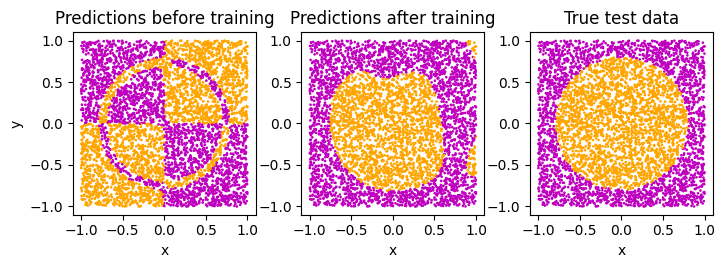

In [4]:
import matplotlib.pyplot as plt

def performance():
    y_0, y_1, y_2 = [], [], []
    for x, y in zip(test_data, test_labels):
        sim.reset()
        sim.apply_circuit(circ, pr=dict(zip(circ.params_name, np.hstack((x, init_params)))))
        expectation = sim.get_expectation(ham).real
        y_0.append('orange' if expectation>=0 else 'm')
        
        sim.reset()
        sim.apply_circuit(circ, pr=dict(zip(circ.params_name, np.hstack((x, best_params)))))
        expectation = sim.get_expectation(ham).real
        y_1.append('orange' if expectation>=0 else 'm')
        
        y_2.append('orange' if y==0 else 'm')
        
        
    
    fig = plt.figure()
    p_0 = fig.add_subplot(131)
    s1 = p_0.scatter(test_data[:,0], test_data[:,1], s=0.9, c=y_0, alpha=1)
    plt.title("Predictions before training")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks([-1,-0.5,0,0.5,1])
    plt.yticks([-1,-0.5,0,0.5,1])
    plt.subplots_adjust(left=0, bottom=0.5,right=1,wspace=0.25)
    
    p_1 = fig.add_subplot(132)
    s2 = p_1.scatter(test_data[:,0], test_data[:,1], s=0.8, c=y_1, alpha=1)
    plt.title("Predictions after training")
    plt.xlabel("x")
    plt.xticks([-1,-0.5,0,0.5,1])
    plt.yticks([-1,-0.5,0,0.5,1])
    
    p_2 = fig.add_subplot(133)
    s3 = p_2.scatter(test_data[:,0], test_data[:,1], s=0.8, c=y_2, alpha=1)
    plt.title("True test data")
    plt.xlabel("x")
    plt.xticks([-1,-0.5,0,0.5,1])
    plt.yticks([-1,-0.5,0,0.5,1])
#     plt.legend((s2,s1),('0','1'),loc=0,shadow=True, fontsize='medium',facecolor='#FFFFFF')
    plt.savefig('data_reuploading_performance.png',format='png', bbox_inches = 'tight')
    plt.show()
    
    
performance()